In [55]:
# Python modules.
import os
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import (
    root_mean_squared_error,
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


# Library.
from src.utils import (
    prepare_submission,
    submit_file,
    get_submission_scores,
)
from src.eda import (
    distplot,
    correlation_heatmap,
    draw_count_plot_to_study_features,
    compare_predictions_and_real_values,
)
from src.preprocessing import (
    fill_df_navalues,
    scale_and_encoder_features,
    split_X_y_in_train_test_sets,
)

In [108]:
# Loading data
df_train = pd.concat([
    pd.read_csv("data/train.csv"),
    pd.read_csv("data/training_extra.csv")
])
print(df_train.shape)
df_test = pd.read_csv("data/test.csv")
column_names = df_train.drop(columns=["id", "Price"]).columns

(3994318, 11)


### EDA

In [109]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


<Figure size 1900x1000 with 0 Axes>

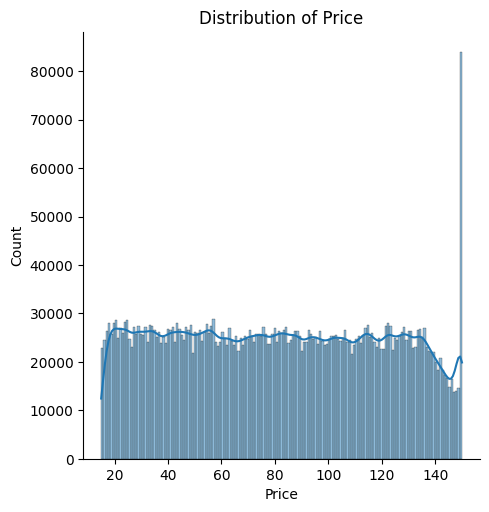

<Figure size 1900x1000 with 0 Axes>

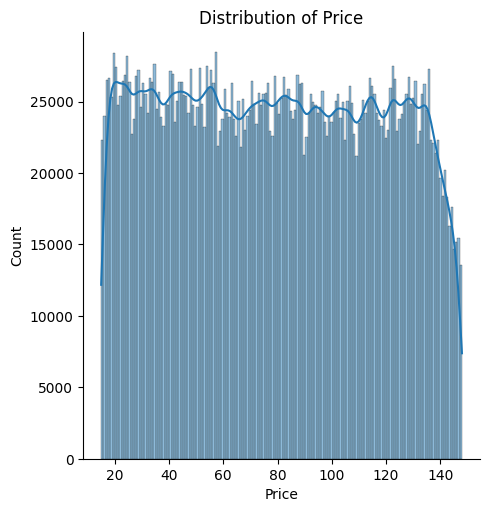

In [111]:
distplot(df=df_train, variable_name="Price")
df_train = df_train.drop(df_train[df_train.Price >= 148].index)
distplot(df=df_train, variable_name="Price")

<Figure size 1900x1000 with 0 Axes>

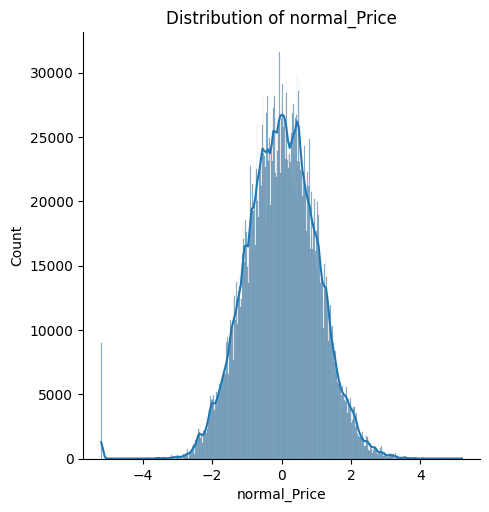

In [120]:
quan = QuantileTransformer(output_distribution="normal", n_quantiles=200)
df_train["normal_Price"] = quan.fit_transform(df_train.loc[:, ["Price"]])

distplot(df=df_train, variable_name="normal_Price")

### Studying features.

ValueError: cannot reindex on an axis with duplicate labels

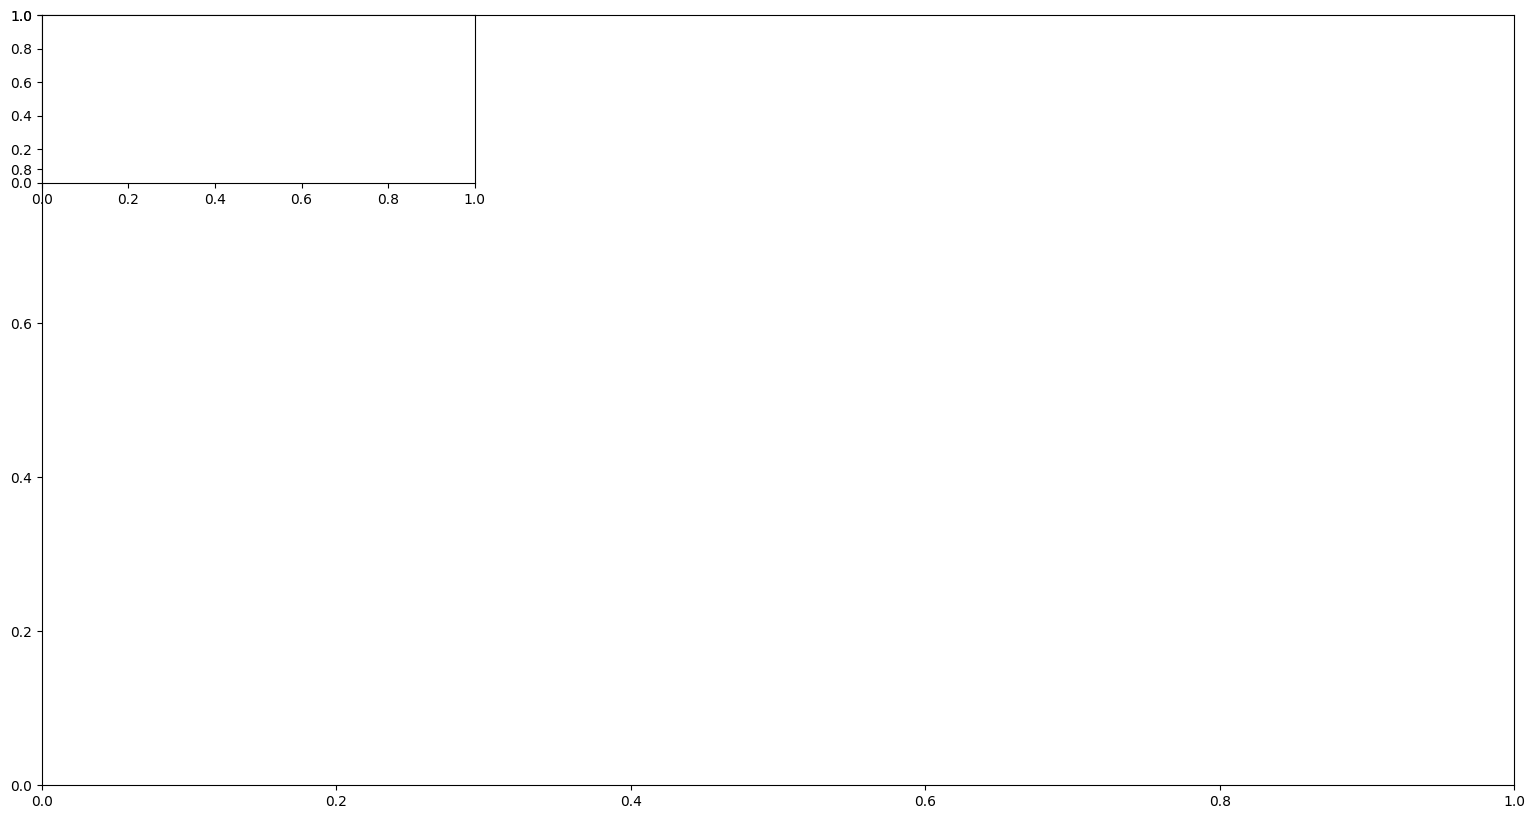

In [121]:
draw_count_plot_to_study_features(df=df_train)

After studying a bit the features, it appears to me that there is no fundamentall distinction between featrues. They do not seems to impact the price so much. Every time I make computation and get the mean price depending on Style, Material or whatever, I ended up having a 80-82 mean pricce.

Useless.

In [ ]:
df_train.groupby(["Brand", "Material", "Style"]).agg({"Price": "mean"})

Price
Brand        Material  Style               
Adidas       Canvas    Backpack   81.634013
                       Messenger  81.692120
                       Tote       81.069860
             Leather   Backpack   79.304768
                       Messenger  80.387837
                       Tote       79.671287
             Nylon     Backpack   79.994290
                       Messenger  80.042028
                       Tote       80.021872
             Polyester Backpack   81.295030
                       Messenger  80.793140
                       Tote       81.250601
Jansport     Canvas    Backpack   82.514452
                       Messenger  82.000725
                       Tote       81.937196
             Leather   Backpack   81.910635
                       Messenger  80.322770
                       Tote       80.256659
             Nylon     Backpack   82.091486
                       Messenger  82.674412
                       Tote       82.074754
             Polyester Backpack   81.788767
                       Messenger  83.350857
                       Tote       81.482549
Nike         Canvas    Backpack   82.327011
                       Messenger  82.492024
                       Tote       81.929173
             Leather   Backpack   80.874444
                       Messenger  79.722102
                       Tote       80.584412
             Nylon     Backpack   80.363496
                       Messenger  80.852628
                       Tote       81.136438
             Polyester Backpack   80.982441
                       Messenger  82.022193
                       Tote       82.921463
Puma         Canvas    Backpack   81.293053
                       Messenger  81.758590
                       Tote       82.823583
             Leather   Backpack   80.564972
                       Messenger  80.852220
                       Tote       79.695995
             Nylon     Backpack   81.466188
                       Messenger  80.318627
                       Tote       81.075294
             Polyester Backpack   81.814347
                       Messenger  81.897673
                       Tote       82.214205
Under Armour Canvas    Backpack   83.418060
                       Messenger  82.476542
                       Tote       82.663583
             Leather   Backpack   80.397187
                       Messenger  80.985548
                       Tote       81.510694
             Nylon     Backpack   81.645616
                       Messenger  81.386811
                       Tote       80.791505
             Polyester Backpack   82.975729
                       Messenger  82.567535
                       Tote       82.604809

## Preprocessing

In [123]:
# Preprocessing
df_train_filled = fill_df_navalues(df=df_train)
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3875978 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          float64
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
 10  normal_Price          float64
dtypes: float64(4), object(7)
memory usage: 483.9+ MB


Then we will remove the outliers.

<Figure size 1900x1000 with 0 Axes>

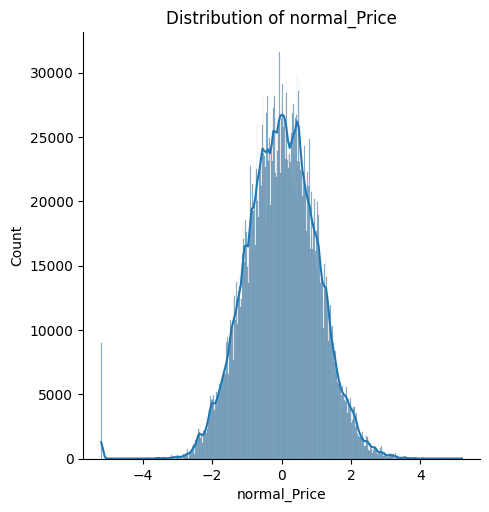

In [124]:
distplot(df=df_train_filled, variable_name="normal_Price")

In [125]:
# Scaling
df_train_filled_n, scalers_and_encoders = scale_and_encoder_features(df=df_train_filled)
df_train_filled_n.info()


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/

<class 'pandas.core.frame.DataFrame'>
Index: 3875978 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 int64  
 1   Material              int64  
 2   Size                  int64  
 3   Compartments          float64
 4   Laptop Compartment    int64  
 5   Waterproof            int64  
 6   Style                 int64  
 7   Color                 int64  
 8   Weight Capacity (kg)  float64
 9   Price                 float64
 10  normal_Price          float64
dtypes: float64(4), int64(7)
memory usage: 483.9 MB


### Correlation matrix.

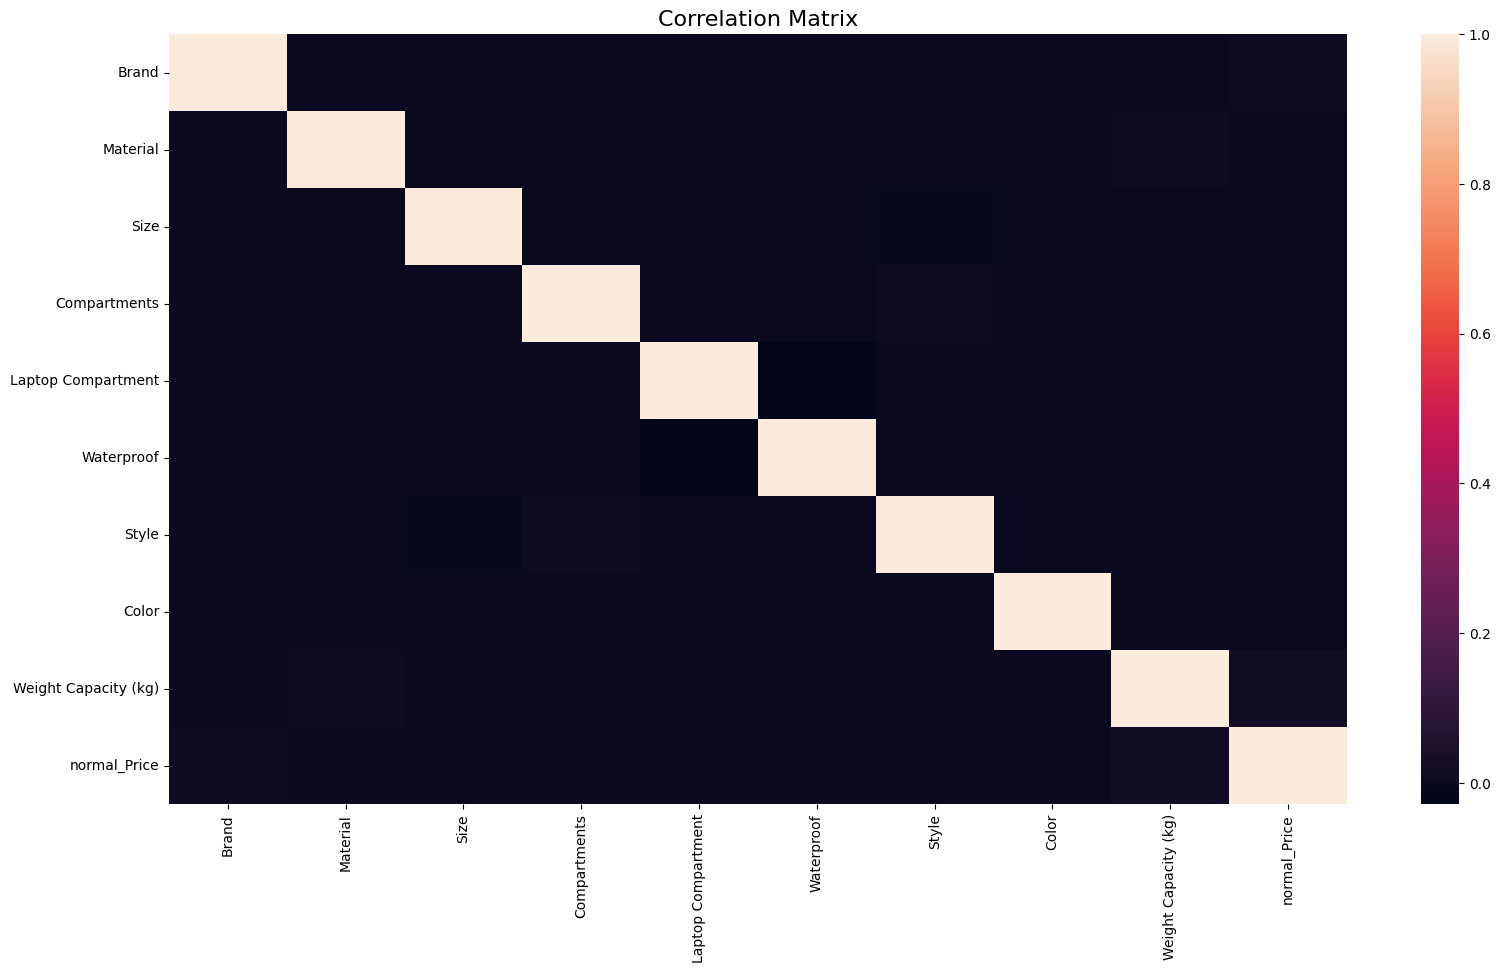

In [126]:
corr = (
    df_train_filled_n
    .select_dtypes(include=["float64", "int64"])
    .drop(columns=["Price", "id", "index"], errors='ignore')
    .corr()
)
correlation_heatmap(df_correlation=corr)

In [127]:
X = df_train_filled_n.loc[:, column_names]
y = df_train_filled_n.loc[:, ["normal_Price"]]
X_train, X_test, y_train, y_test = split_X_y_in_train_test_sets(X=X, y=y)

In [128]:
model = LinearRegression()
model2 = RandomForestRegressor()
model.fit(X_train, y_train)
model2.fit(X_train, y_train)

/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [129]:
score = model2.score(X_test, y_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=model2.predict(X_test))
# intercept = model.intercept_
# coeff = model.coef_
print(f"Score: {score:.2f}") # vs {score_l:.2f} vs {score_rf:.2f}")
print(f"RMSE: {rmse:.2f}") # vs {rmse_l:.2f} vs {rmse_rf:.2f}")

In [ ]:
X_test["normal_Price_prediction"] = model2.predict(X_test[column_names])
X_test["normal_Price"] = y_test.loc[:, ["normal_Price"]]
X_test

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),normal_Price_prediction,normal_Price
4941,1,1,0,0.111111,2,2,2,1,0.895206,0.655256,0.676148
51775,3,0,1,0.222222,0,0,1,4,0.502289,0.663774,0.423169
115253,1,0,2,0.111111,2,0,2,5,0.764560,0.580161,0.701962
299321,4,3,0,0.666667,0,0,1,1,0.397238,0.626447,0.260147
173570,3,1,2,0.666667,0,0,2,2,0.611751,0.595018,0.345163
...,...,...,...,...,...,...,...,...,...,...,...
18305,4,2,0,0.111111,0,2,1,5,0.637658,0.632967,0.851044
218340,1,0,2,0.666667,2,0,2,2,0.331189,0.597432,0.651256
114216,1,2,1,0.555556,0,0,2,3,0.827469,0.661922,0.419669
172565,1,0,2,0.111111,0,0,2,5,0.383798,0.678156,0.707395


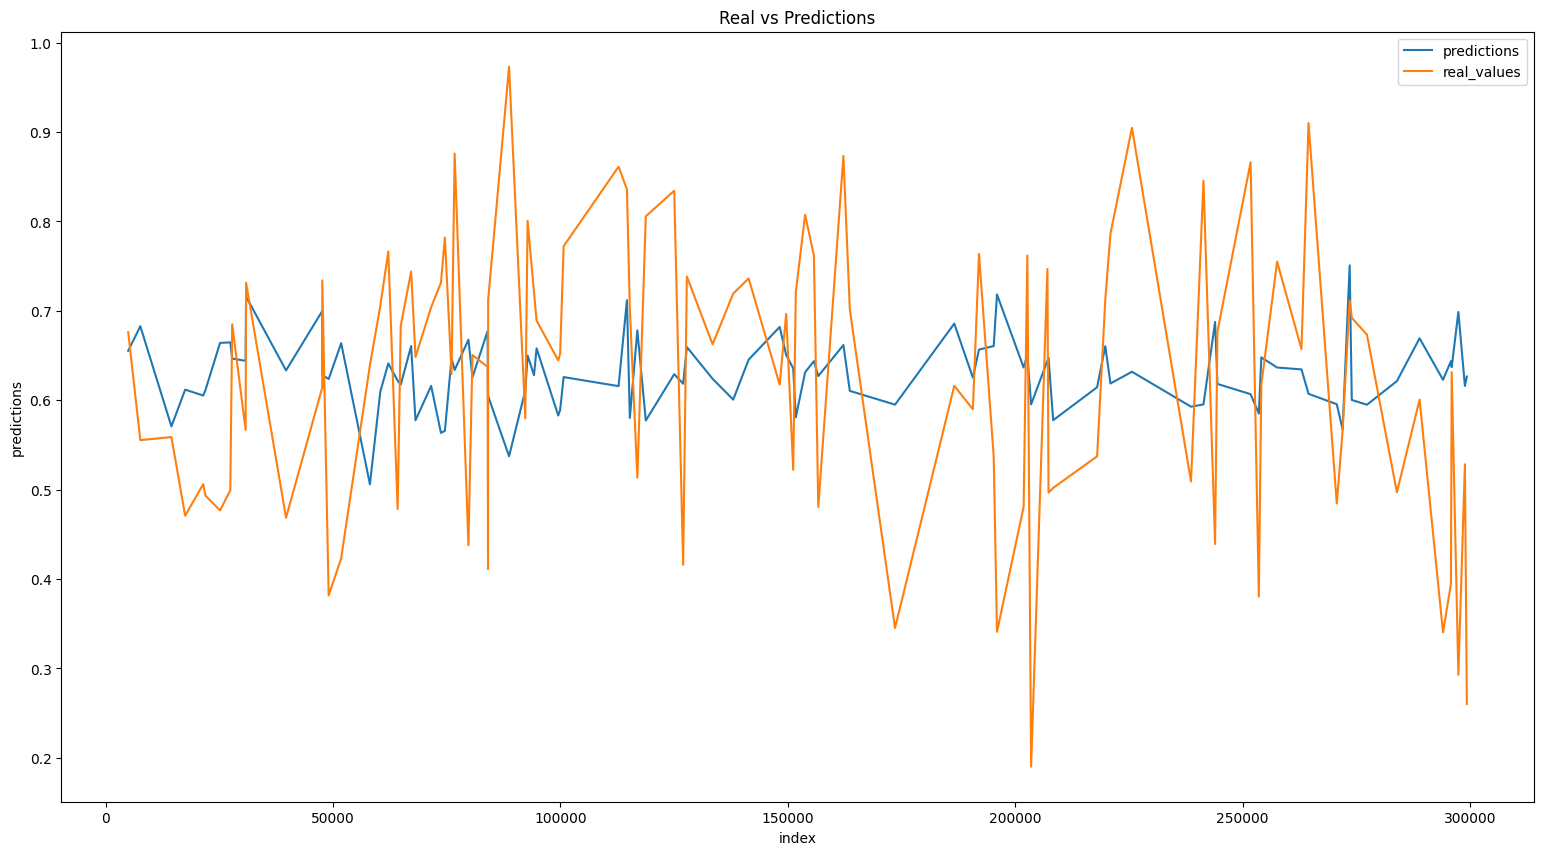

In [ ]:
compare_predictions_and_real_values(
    df=X_test.loc[:, ["normal_Price_prediction", "normal_Price"]].rename(columns={
        "normal_Price_prediction": "predictions",
        "normal_Price": "real_values",
        }).reset_index().iloc[:100],
)

Linear regression is not a good model for this problem.

In [76]:
df_test_filled = fill_df_navalues(df=df_test)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  object 
 2   Material              200000 non-null  object 
 3   Size                  200000 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  object 
 6   Waterproof            200000 non-null  object 
 7   Style                 200000 non-null  object 
 8   Color                 200000 non-null  object 
 9   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [ ]:
df_test_filled_n = df_test_filled.copy()
for column_name in df_test_filled_n.columns:
    if column_name == "id":
        continue
    df_test_filled_n[column_name] = (
        scalers_and_encoders[column_name]
        .transform(df_test_filled_n.loc[:, [column_name]])
    )

df_test_filled_n.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  int64  
 2   Material              200000 non-null  int64  
 3   Size                  200000 non-null  int64  
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  int64  
 6   Waterproof            200000 non-null  int64  
 7   Style                 200000 non-null  int64  
 8   Color                 200000 non-null  int64  
 9   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 15.3 MB


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, 

In [ ]:
df_test_filled_n["normal_Price_prediction"] = model2.predict(df_test_filled_n.loc[:, column_names])
df_test_filled_n["Price_prediction"] = scalers_and_encoders["normal_Price"].inverse_transform(df_test_filled_n.loc[:, ["normal_Price_prediction"]])
df_test_filled_n["Price_prediction_inv_quant"] = quan.inverse_transform(df_test_filled_n.remane(columns={"Price_prediction": "Price"}).loc[:, ["Price"]])
df_test_filled_n

<Figure size 1900x1000 with 0 Axes>

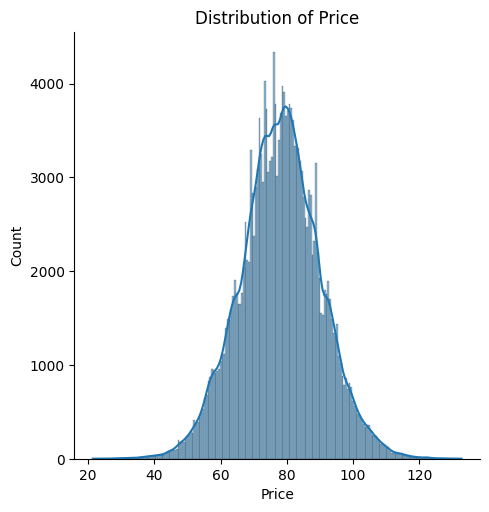

In [ ]:
distplot(df=df_test_filled_n, variable_name="Price_prediction")
distplot(df=df_test_filled_n, variable_name="Price_prediction_inv_quant")

In [89]:
prepare_submission(df_predictions=df_test_filled_n.rename(columns={"Price": "prediction"}))

Generating output: data/my_submission.csv.


In [90]:
submit_file(message="Random forest")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.49M/2.49M [00:01<00:00, 2.02MB/s]


In [95]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
42830901 - 40.97361 -  - 2025-02-11 15:16:50
42770810 - 40.92468 -  - 2025-02-08 11:06:30
42753436 - 90.27426 -  - 2025-02-07 14:09:37
42753425 -  -  - 2025-02-07 14:08:43
42753373 -  -  - 2025-02-07 14:05:28
42751414 - 47.83047 -  - 2025-02-07 11:28:51
42751405 - 61.44125 -  - 2025-02-07 11:27:19
42751147 - 39.16456 -  - 2025-02-07 11:01:47
42751114 - 39.16456 -  - 2025-02-07 10:59:07
